In [40]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [41]:
# %matplotlib inline

In [42]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [43]:
# device=t.device('cpu') #Overrride the above device choice

Generate the sample 2D distribution: uniform from unit circle.  

In [44]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

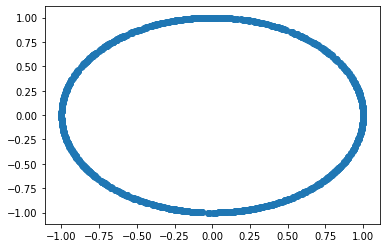

In [45]:
plt.scatter(data[:,0], data[:,1])

In [46]:
data_t = t.from_numpy(data)

In [47]:
data_t

tensor([[ 0.7493,  0.6623],
        [ 0.7121, -0.7021],
        [ 0.7539, -0.6570],
        ...,
        [ 0.8783, -0.4782],
        [ 0.5929,  0.8052],
        [ 0.9997,  0.0238]])

In [93]:
discriminator = Sequential(
    Linear(2,50),
    ReLU(),
    Linear(50,100),
    ReLU(),
    Linear(100,100),
    ReLU(),
    Linear(100,50),
    ReLU(),
    Linear(50,1),
    Sigmoid()) #dummy discriminator: please subsitute you own implementation 

In [94]:
discriminator = discriminator.to(device) 

In [95]:
generator = Sequential(
    Linear(2,50),
    ReLU(),
    Linear(50,100),
    ReLU(),
    Linear(100,100),
    ReLU(),
    Linear(100,50),
    ReLU(),
    Linear(50,2),
)# dummy generator: please subsitute you own implementation 

In [96]:
generator= generator.to(device)

In [97]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));

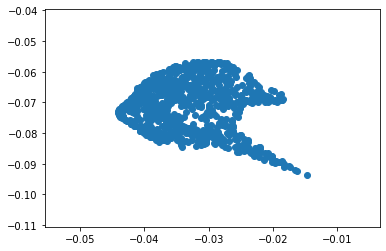

In [98]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [99]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.02)

In [100]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.02)

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

In [107]:
lossfn = t.nn.BCELoss().cuda()
batch_size = 100

for epoch in range(1000):
    angle = np.random.uniform(-np.pi,np.pi,(batch_size,1)).astype('float32')
    real = t.from_numpy(np.concatenate((np.cos(angle), np.sin(angle)),axis=1)).to(device)
    fake_points = generator(t.empty(batch_size,2, device=device).uniform_(-1,1))
    
    print(discriminator(real).requires_grad)
    
    valid = t.ones([batch_size,1]).to(device)
    fake = t.zeros([batch_size,1]).to(device)
        
    
    a = list(generator.parameters())[0].clone()
    
    g_optimizer.zero_grad()
    gloss = lossfn(discriminator(fake_points),valid)
    gloss.backward()
    print(a.grad)
    g_optimizer.step()

    b = list(generator.parameters())[0].clone()
    print(t.equal(a.data, b.data))
    print(b.grad)
    
    break

    d_optimizer.zero_grad()
    dloss_real = lossfn(discriminator(real),valid)
    dloss_fake = lossfn(discriminator(fake_points.detach()),fake)
    dloss = (dloss_fake+dloss_real)/2
    dloss.backward()
    d_optimizer.step()
    

    
    if epoch%200==0:
        print("[Epoch %d] [D loss: %f] [G loss: %f]"%(epoch, dloss.item(), gloss.item()))
        real = real.detach().cpu().numpy()
        fake_points = fake_points.detach().cpu().numpy()
        plt.scatter(real[:,0],real[:,1])
        plt.scatter(fake_points[:,0],fake_points[:,1])
        plt.show()




# 
# for epoch in range(100):
#     for datum in train_loader:
#         optimizer.zero_grad()
#         (features, target) = datum
#         pred = model(features.to('cuda'))
#         loss = loss_func(pred, target.to('cuda'))
#         loss.backward()
#         optimizer.step()
# 
#     with torch.no_grad():
#         vpred = model(valid_set[:][0].to('cuda'))
#         vloss = loss_func(vpred, valid_set[:][1].to('cuda'))
#         err_valid.append(vloss)
#         pred = model(train_set[:][0].to('cuda'))
#         loss = loss_func(pred, train_set[:][1].to('cuda'))
#         err_train.append(loss)

True
None
False
None


### Problem 2

Use another sampling distribution. One that is not concentrated on a line e.g. an ellipse. 